In [14]:
import os
import sys
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


class StderrFilter:
    """Filter untuk menekan log C++ dari MediaPipe/TensorFlow."""

    def __init__(self, original_stderr):
        self.original_stderr = original_stderr

    def write(self, message):
        suppressed_patterns = [
            "FaceBlendshapesGraph acceleration to xnnpack",
            "Feedback manager requires a model",
            "Sets FaceBlendshapesGraph",
            "Created TensorFlow Lite XNNPACK delegate",
        ]
        if message.strip() == "":
            return
        if any(pattern in message for pattern in suppressed_patterns):
            return
        self.original_stderr.write(message)

    def flush(self):
        self.original_stderr.flush()


sys.stderr = StderrFilter(sys.stderr)
warnings.filterwarnings('ignore')

In [ ]:
sys.path.append('..')
import module

import math
import time
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from src.apex.modules import ApexWindowDataSource, ApexFullPhaseDataSource, ApexHybridDataSource

In [ ]:
STRATEGY      = "full_phase"
K             = 5
TARGET_LENGTH = 32
MODE          = "roi"
MAX_SUBJECTS  = None

EPOCHS             = 50
BATCH_SIZE         = 16   # T1-D: dinaikkan dari 4 agar GPU SM lebih terisi
DATALOADER_WORKERS = 4    # T1-B: worker proses paralel untuk DataLoader
LEARNING_RATE      = 1e-4
WARMUP_EPOCHS      = 5
WARMUP_START_LR    = 1e-6
COSINE_END_LR      = 1e-6
LABEL_SMOOTHING    = 0.1
GRAD_CLIP_NORM     = 1.0
EARLY_STOP_PATIENCE = 10
EARLY_STOP_DELTA   = 0.005

K_FOLD    = 5   # number of cross-subject folds
FOLD_IDX  = 0   # fold to use in this run (0 … K_FOLD-1)

SEED               = 42

OUT_DIM            = 64

CHECKPOINT_DIR = os.path.join(Path.cwd(), "..", "checkpoints-mobilenet-v3")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)
# T1-C: benchmark=True agar cuDNN memilih algoritma tercepat untuk shape tetap.
# deterministic=False diperlukan agar benchmark bekerja.
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark     = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
import torch.nn.functional as _F


def coarse_patch_dropout(tensor, patch_size=4, n_patches=3):
    """P2: zero random 4×4 patches on apex frame (C,H,W) tensor [0,1]."""
    c, h, w = tensor.shape
    out = tensor.clone()
    for _ in range(n_patches):
        y0 = np.random.randint(0, max(1, h - patch_size + 1))
        x0 = np.random.randint(0, max(1, w - patch_size + 1))
        out[:, y0:y0 + patch_size, x0:x0 + patch_size] = 0.0
    return out


class SpatialStream(nn.Module):
    """Stream spasial menggunakan pretrained MobileNetV3-Small sebagai backbone.

    Strategy: freeze early layers (fitur edge/texture universal dari ImageNet),
    fine-tune later layers (fitur semantik task-specific).
    Input : (B, 3, 224, 224) — RGB apex frame, ImageNet-normalized.
    Output: (B, out_dim) — spatial feature vector.
    """

    def __init__(self, out_dim: int = 64, freeze_blocks: int = 10):
        super().__init__()

        backbone = torchvision.models.mobilenet_v3_small(
            weights='IMAGENET1K_V1'
        )
        self.features = backbone.features  # Sequential of InvertedResidual blocks

        # P2: Freeze first `freeze_blocks` blocks (10 out of 13 — preserve more general features)
        for i, block in enumerate(self.features):
            if i < freeze_blocks:
                for param in block.parameters():
                    param.requires_grad = False

        # MobileNetV3-Small features output: (B, 576, 7, 7)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(576, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)       # (B, 576, 7, 7)
        x = self.pool(x)           # (B, 576, 1, 1)
        x = x.flatten(1)           # (B, 576)
        x = self.dropout(x)
        return self.fc(x)          # (B, out_dim)

In [18]:
class TemporalStream(nn.Module):
    """Stream temporal untuk mengekstrak fitur dari stacked optical flow.

    Channel progression: in_channels → 16 → 16 → 32 → 32 → 64
    Kernel 5×5 pertama menangkap pola motion yang lebih lebar.
    Dropout2d disisipkan setelah setiap MaxPool dan AdaptiveAvgPool.
    """

    def __init__(self, in_channels: int, out_dim: int = 64):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1: tangkap pola motion awal dengan kernel 5×5 yang lebih lebar
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            # Block 2: refinement pola motion (16 → 16 channel)
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),   # spasial ÷ 2
            nn.Dropout2d(p=0.15),

            # Block 3: transisi ke fitur motion mid-level (16 → 32 channel)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Block 4: pendalaman fitur motion (32 → 32 channel)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),   # spasial ÷ 4
            nn.Dropout2d(p=0.15),

            # Block 5: fitur motion high-level (32 → 64 channel)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Global pooling: kompresi spasial ke vektor 64-dim
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Dropout2d(p=0.3),
        )

        # Proyeksi ke dimensi output
        self.fc = nn.Linear(in_features=64, out_features=out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.flatten(1)
        return self.fc(x)

In [19]:
class DualStreamNet(nn.Module):
    """Two-stream CNN: gabungan spatial dan temporal stream untuk klasifikasi."""

    def __init__(self, in_channels: int, out_dim: int = 64, num_classes: int = 2):
        super().__init__()
        self.spatial_stream = SpatialStream(out_dim=out_dim)
        self.temporal_stream = TemporalStream(in_channels=in_channels, out_dim=out_dim)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=out_dim * 2, out_features=64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=64, out_features=num_classes),
        )

    def forward(self, apex_image: torch.Tensor, flow_stack: torch.Tensor) -> torch.Tensor:
        spatial_features = self.spatial_stream(apex_image)
        temporal_features = self.temporal_stream(flow_stack)
        fused = torch.cat([spatial_features, temporal_features], dim=1)
        return self.classifier(fused)

In [20]:
# ImageNet normalization constants
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)


def imagenet_normalize(tensor):
    """Normalisasi tensor RGB [0,1] dengan mean/std ImageNet."""
    return (tensor - IMAGENET_MEAN) / IMAGENET_STD


def _hue_shift(tensor_rgb, hue_deg):
    """Shift hue by hue_deg degrees on an RGB tensor (3,H,W) in [0,1]."""
    # Convert RGB → HSV via numpy for simplicity
    img_np = tensor_rgb.permute(1, 2, 0).numpy()   # (H,W,3)
    img_bgr = (img_np[..., ::-1] * 255).astype(np.uint8)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    img_hsv[..., 0] = (img_hsv[..., 0] + hue_deg) % 180.0
    img_bgr_shifted = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    img_rgb_shifted = img_bgr_shifted[..., ::-1].astype(np.float32) / 255.0
    return torch.from_numpy(img_rgb_shifted.copy()).permute(2, 0, 1)


def augment_apex(tensor):
    """Augmentasi untuk RGB apex frame (3, H, W) normalized [0,1].

    Transforms preserving micro-expression AU topology:
    - Horizontal flip (p=0.5)
    - Random rotation ±8° (p=0.4)           [P0 widened from ±5°]
    - HSV hue jitter ±10° (p=0.35)           [P0 breaks skin-colour proxy]
    - Brightness jitter ×[0.85,1.15] (p=0.3)
    - Contrast jitter ×[0.85,1.15] (p=0.3)
    - Additive Gaussian noise σ=0.01 (p=0.2)
    - Coarse patch dropout 4×4 patches (p=0.25) [P2]
    """
    flip = False

    # Horizontal flip
    if np.random.random() < 0.5:
        tensor = torch.flip(tensor, dims=[2])
        flip = True

    # Random rotation ±8° (P0: widened from ±5°)
    if np.random.random() < 0.4:
        angle = np.random.uniform(-8.0, 8.0)
        theta = torch.tensor([
            [np.cos(np.radians(angle)), -np.sin(np.radians(angle)), 0],
            [np.sin(np.radians(angle)),  np.cos(np.radians(angle)), 0],
        ], dtype=torch.float32).unsqueeze(0)
        grid = F.affine_grid(theta, tensor.unsqueeze(0).size(), align_corners=False)
        tensor = F.grid_sample(tensor.unsqueeze(0), grid, align_corners=False).squeeze(0)

    # P0: HSV hue jitter ±10° — breaks skin-colour subject proxy
    if np.random.random() < 0.35:
        hue_delta = np.random.uniform(-10.0, 10.0)
        tensor = _hue_shift(tensor, hue_delta)

    # Brightness jitter
    if np.random.random() < 0.3:
        factor = np.random.uniform(0.85, 1.15)
        tensor = tensor * factor

    # Contrast jitter (per-channel mean for RGB)
    if np.random.random() < 0.3:
        mean_val = tensor.mean(dim=[1, 2], keepdim=True)
        factor = np.random.uniform(0.85, 1.15)
        tensor = (tensor - mean_val) * factor + mean_val

    # Additive Gaussian noise
    if np.random.random() < 0.2:
        noise = torch.randn_like(tensor) * 0.01
        tensor = tensor + noise

    # P2: Coarse patch dropout
    if np.random.random() < 0.25:
        tensor = coarse_patch_dropout(tensor)

    tensor = tensor.clamp(0.0, 1.0)
    return tensor, flip


def augment_flow(flow_flat, flip):
    """Augmentasi untuk stacked optical flow (2T, H, W).

    Transforms preserving vector field structure:
    - Horizontal flip + negate dx (synchronized with apex flip)
    - Magnitude scaling ×[0.85,1.20] (p=0.5)  [P1: widened range]
    - Additive Gaussian noise σ=0.01 (p=0.3)
    - Blank frame injection: zero 1–2 frame pairs (p=0.2)  [P1]
    - Per-frame dropout: zero 1 frame pair (p=0.2)
    """
    num_channels = flow_flat.shape[0]

    # Synchronized horizontal flip — negate dx channels (even indices)
    if flip:
        flow_flat = torch.flip(flow_flat, dims=[2])
        for c in range(0, num_channels, 2):
            flow_flat[c] = -flow_flat[c]

    # Magnitude scaling (P1: [0.85, 1.20])
    if np.random.random() < 0.5:
        scale = np.random.uniform(0.85, 1.20)
        flow_flat = flow_flat * scale

    # Additive Gaussian noise
    if np.random.random() < 0.3:
        noise = torch.randn_like(flow_flat) * 0.01
        flow_flat = flow_flat + noise

    # P1: Blank frame injection — zero 1–2 random (dx,dy) frame pairs
    if np.random.random() < 0.2:
        num_frames = num_channels // 2
        n_blank = np.random.randint(1, min(3, num_frames + 1))
        blank_indices = np.random.choice(num_frames, n_blank, replace=False)
        for idx in blank_indices:
            flow_flat[idx * 2]     = 0.0
            flow_flat[idx * 2 + 1] = 0.0

    # Per-frame dropout: zero 1 random frame pair
    if np.random.random() < 0.2:
        num_frames = num_channels // 2
        drop_idx = np.random.randint(0, num_frames)
        flow_flat[drop_idx * 2]     = 0.0
        flow_flat[drop_idx * 2 + 1] = 0.0

    # P3: Dynamic Temporal Jittering (Phase Shift)
    if np.random.random() < 0.4:
        num_frames = num_channels // 2
        shift = np.random.randint(-2, 3)
        if shift != 0:
            flow_reshaped = flow_flat.view(num_frames, 2, flow_flat.shape[1], flow_flat.shape[2])
            flow_reshaped = torch.roll(flow_reshaped, shifts=shift, dims=0)
            flow_flat = flow_reshaped.view(-1, flow_flat.shape[1], flow_flat.shape[2])

    return flow_flat

In [21]:
if STRATEGY == "window":
    dataset = ApexWindowDataSource(k=K, mode=MODE, max_subjects=MAX_SUBJECTS)
    num_flow_frames = 2 * K + 1
elif STRATEGY == "full_phase":
    dataset = ApexFullPhaseDataSource(target_length=TARGET_LENGTH, mode=MODE, max_subjects=MAX_SUBJECTS)
    num_flow_frames = TARGET_LENGTH
elif STRATEGY == "hybrid":
    dataset = ApexHybridDataSource(target_length=TARGET_LENGTH, mode=MODE, max_subjects=MAX_SUBJECTS)
    num_flow_frames = TARGET_LENGTH
else:
    raise ValueError(f"Unknown strategy: {STRATEGY}")

FLOW_CHANNELS = num_flow_frames * 2


# ── P0: Subject-stratified GroupKFold split ──────────────────────────────────
def _get_subject_id(video_path: str) -> str:
    """Extract the subject directory name from a video path.

    Path structure: .../BEFORE 9-12-2025/<subject_dir>/q<n>/<file>.avi
    We use the subject_dir (grandparent of the file) as the group key.
    """
    from pathlib import Path as _P
    return _P(video_path).parts[-3]  # e.g. 'duta_kurnia_ardhani_1765255548331'


all_video_paths = [video_path for video_path, _ in dataset.datasource]
all_labels      = [label for _, label in dataset.datasource]
groups          = [_get_subject_id(p) for p in all_video_paths]

# Map string label to int (mirroring LABEL_MAP inside datasource)
_LABEL_MAP = {"anxiety": 1, "non-anxiety": 0}
group_labels_int = [_LABEL_MAP.get(lbl, 0) for lbl in all_labels]

gkf = GroupKFold(n_splits=K_FOLD)
splits = list(gkf.split(all_video_paths, group_labels_int, groups))
train_indices, val_indices = splits[FOLD_IDX]

train_dataset = Subset(dataset, train_indices.tolist())
val_dataset   = Subset(dataset, val_indices.tolist())

print(f"Fold {FOLD_IDX}/{K_FOLD}: train={len(train_dataset)}, val={len(val_dataset)}")
unique_train_subjects = len(set(groups[i] for i in train_indices))
unique_val_subjects   = len(set(groups[i] for i in val_indices))
print(f"  Train subjects: {unique_train_subjects}, Val subjects: {unique_val_subjects}")


# ── P0: Class-balanced WeightedRandomSampler ─────────────────────────────────
train_label_ints = [group_labels_int[i] for i in train_indices]
class_counts = [train_label_ints.count(0), train_label_ints.count(1)]
# weight for each sample = inverse class frequency
class_weights_sampler = [
    1.0 / max(class_counts[lbl], 1) for lbl in train_label_ints
]
sampler = WeightedRandomSampler(
    weights=class_weights_sampler,
    num_samples=int(len(train_dataset) * 1.5),  # oversample 1.5×
    replacement=True,
)


# ── Collate functions ─────────────────────────────────────────────────────────
def collate_fn(batch, augment=False):
    """Konversi output datasource ke format input DualStreamNet.

    Datasource output per sample:
        flows:  (T, H, W, 2)  — optical flow
        frames: (T, H, W, 3)  — BGR frames
        label:  int

    Model input:
        apex_image: (B, 3, 224, 224) — RGB apex frame, ImageNet-normalized
        flow_stack: (B, 2T, H, W)    — stacked flow channels
        labels:     (B,)             — integer labels
    """
    apex_images, flow_stacks, labels = [], [], []

    for flows, frames, label in batch:
        temporal_length = flows.shape[0]

        apex_idx = temporal_length // 2

        # P3: Subordinate RGB stream by taking difference (apex - onset)
        apex_bgr = frames[apex_idx].numpy().astype(np.float32)
        onset_bgr = frames[0].numpy().astype(np.float32)
        diff_bgr = np.clip((apex_bgr - onset_bgr) + 128.0, 0, 255).astype(np.uint8)

        # BGR → RGB, resize ke 224×224 untuk MobileNetV3
        diff_rgb = cv2.cvtColor(diff_bgr, cv2.COLOR_BGR2RGB)
        diff_rgb = cv2.resize(diff_rgb, (224, 224), interpolation=cv2.INTER_LINEAR)
        # (H, W, 3) → (3, H, W), normalize ke [0, 1]
        apex_tensor = torch.from_numpy(diff_rgb).float().permute(2, 0, 1) / 255.0

        flow_reshaped = flows.permute(0, 3, 1, 2)
        flow_flat = flow_reshaped.reshape(-1, flow_reshaped.shape[2], flow_reshaped.shape[3])
        
        # P3: Normalize flow locally per-sample per-channel
        f_mean = flow_flat.mean(dim=[1, 2], keepdim=True)
        f_std = flow_flat.std(dim=[1, 2], keepdim=True)
        flow_flat = (flow_flat - f_mean) / (f_std + 1e-5)

        if augment:
            apex_tensor, flip = augment_apex(apex_tensor)
            flow_flat = augment_flow(flow_flat, flip)

        # Apply ImageNet normalization setelah augmentasi
        apex_tensor = imagenet_normalize(apex_tensor)

        apex_images.append(apex_tensor)
        flow_stacks.append(flow_flat)
        labels.append(label)

    # T1-B: kembalikan tensor CPU — transfer ke GPU dilakukan
    # secara async oleh DataLoader setelah worker mengembalikan batch.
    return (
        torch.stack(apex_images),
        torch.stack(flow_stacks),
        torch.tensor(labels, dtype=torch.long),
    )


train_collate = lambda batch: collate_fn(batch, augment=True)
val_collate   = lambda batch: collate_fn(batch, augment=False)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
    collate_fn=train_collate,
    num_workers=DATALOADER_WORKERS,   # T1-B: parallel prefetch
    pin_memory=True,                   # T1-B: faster CPU→GPU transfer
    persistent_workers=DATALOADER_WORKERS > 0,  # hindari respawn tiap epoch
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=val_collate,
    num_workers=DATALOADER_WORKERS,
    pin_memory=True,
    persistent_workers=DATALOADER_WORKERS > 0,
)

[SKIP] Unreadable video: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/duta_kurnia_ardhani_1765255548331/q1/answer_1_15d591ce-051a-47f2-ac38-367c1e6189c7_sec.avi - Cannot open video file: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/duta_kurnia_ardhani_1765255548331/q1/answer_1_15d591ce-051a-47f2-ac38-367c1e6189c7_sec.avi
[SKIP] Unreadable video: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/duta_kurnia_ardhani_1765255548331/q2/answer_2_490a0a4a-d935-4509-9a4e-fb0a393be5b9_sec.avi - Cannot open video file: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/duta_kurnia_ardhani_1765255548331/q2/answer_2_490a0a4a-d935-4509-9a4e-fb0a393be5b9_sec.avi
[SKIP] Unreadable video: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/duta_kurnia_ardhani_1765255548331/q3/answer_3_ce8ef7e8-63e6-46c1-a510-1b8269c27ce7_sec.avi - Cannot open video file: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/duta_kurnia_ardhani_1765255548331/q3/answer_3_ce8e

In [22]:
model = DualStreamNet(
    in_channels=FLOW_CHANNELS,
    out_dim=OUT_DIM,
    num_classes=2,
).to(device)

# Class weighting: effective number of samples (Cui et al. 2019)
beta = 0.99
train_labels_int = [group_labels_int[i] for i in train_indices]
class_counts = [train_labels_int.count(0), train_labels_int.count(1)]
effective_num = [1.0 - beta ** c for c in class_counts]
class_weights = torch.tensor([(1.0 - beta) / en for en in effective_num])
class_weights = class_weights / class_weights.sum() * 2.0

criterion = nn.CrossEntropyLoss(
    weight=class_weights.to(device),
    label_smoothing=LABEL_SMOOTHING,
)

# Parameter groups: differential LR untuk pretrained backbone
# Backbone layers yang di-unfreeze: LR 10x lebih rendah agar tidak merusak fitur ImageNet
optimizer = torch.optim.Adam([
    {"params": [p for p in model.spatial_stream.features.parameters() if p.requires_grad],
     "lr": LEARNING_RATE * 0.1, "weight_decay": 1e-4},
    {"params": model.spatial_stream.fc.parameters(), "weight_decay": 1e-3},
    {"params": model.temporal_stream.features.parameters(), "weight_decay": 5e-4},
    {"params": model.temporal_stream.fc.parameters(), "weight_decay": 1e-3},
    {"params": model.classifier.parameters(), "weight_decay": 1e-3},
], lr=LEARNING_RATE)


# Linear warmup + cosine annealing schedule
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return WARMUP_START_LR / LEARNING_RATE + (1.0 - WARMUP_START_LR / LEARNING_RATE) * epoch / WARMUP_EPOCHS
    progress = (epoch - WARMUP_EPOCHS) / max(EPOCHS - WARMUP_EPOCHS, 1)
    return (COSINE_END_LR / LEARNING_RATE) + 0.5 * (1.0 - COSINE_END_LR / LEARNING_RATE) * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Training satu epoch dengan gradient clipping, return avg_loss dan accuracy."""
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for apex_images, flow_stacks, labels in tqdm(loader, desc="Training", leave=False):
        # T1-B: transfer ke GPU di sini (tensor sudah pin-memory dari worker)
        apex_images = apex_images.to(device, non_blocking=True)
        flow_stacks = flow_stacks.to(device, non_blocking=True)
        labels      = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(apex_images, flow_stacks)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP_NORM)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy


@torch.no_grad()
def validate(model, loader, criterion):
    """Validasi model, return (loss, acc, precision, recall, f1, preds, labels)."""
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for apex_images, flow_stacks, labels in tqdm(loader, desc="Validating", leave=False):
        apex_images = apex_images.to(device, non_blocking=True)
        flow_stacks = flow_stacks.to(device, non_blocking=True)
        labels      = labels.to(device, non_blocking=True)
        outputs = model(apex_images, flow_stacks)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / max(len(loader), 1)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall_val = recall_score(all_labels, all_preds, zero_division=0)
    f1_val = f1_score(all_labels, all_preds, zero_division=0)

    return avg_loss, accuracy, precision, recall_val, f1_val, all_preds, all_labels

In [24]:
history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": [],
    "val_precision": [], "val_recall": [], "val_f1": [],
    "lr": [],
}

best_val_loss = float("inf")
best_epoch = 0
patience_counter = 0

epoch_pbar = tqdm(range(1, EPOCHS + 1), desc="Epochs")
for epoch in epoch_pbar:
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)

    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = validate(model, val_loader, criterion)

    current_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()

    elapsed = time.time() - start_time

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_precision"].append(val_prec)
    history["val_recall"].append(val_rec)
    history["val_f1"].append(val_f1)
    history["lr"].append(current_lr)

    improved = ""
    if val_loss < best_val_loss - EARLY_STOP_DELTA:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"best_model_{STRATEGY}_fold{FOLD_IDX}.pt")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
            "val_acc": val_acc,
            "strategy": STRATEGY,
            "flow_channels": FLOW_CHANNELS,
        }, checkpoint_path)
        improved = " ★ saved"
    else:
        patience_counter += 1

    epoch_pbar.set_postfix_str(
        f"TL: {train_loss:.4f} TA: {train_acc:.3f} | "
        f"VL: {val_loss:.4f} VA: {val_acc:.3f} F1: {val_f1:.3f} | "
        f"LR: {current_lr:.2e} | {elapsed:.1f}s{improved}"
    )

    if patience_counter >= EARLY_STOP_PATIENCE:
        epoch_pbar.close()
        break

Processing [317]: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/fahmi_yahya_1765259059086/q3/answer_3_ce8ef7e8-63e6-46c1-a510-1b8269c27ce7_sec.avi
[SKIP] Process error: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/fahmi_yahya_1765259059086/q3/answer_3_ce8ef7e8-63e6-46c1-a510-1b8269c27ce7_sec.avi - Could not read frame 1170 from /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/fahmi_yahya_1765259059086/q3/answer_3_ce8ef7e8-63e6-46c1-a510-1b8269c27ce7_sec.avi
Processing [317]: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/fahmi_yahya_1765259059086/q3/answer_3_ce8ef7e8-63e6-46c1-a510-1b8269c27ce7_sec.avi
[SKIP] Process error: /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/fahmi_yahya_1765259059086/q3/answer_3_ce8ef7e8-63e6-46c1-a510-1b8269c27ce7_sec.avi - Could not read frame 1170 from /home/inadio/datasets/primary-converted/BEFORE 9-12-2025/fahmi_yahya_1765259059086/q3/answer_3_ce8ef7e8-63e6-46c1-a510-1b8269c27ce7_sec.avi
Processing [31

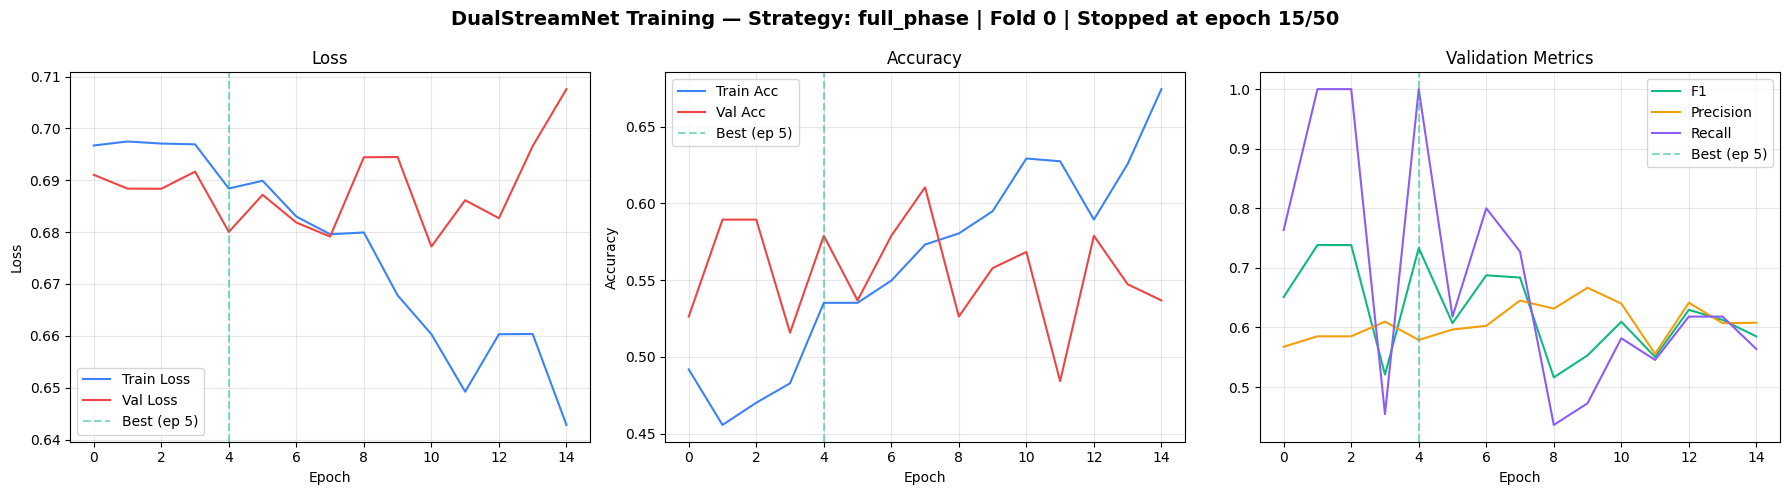

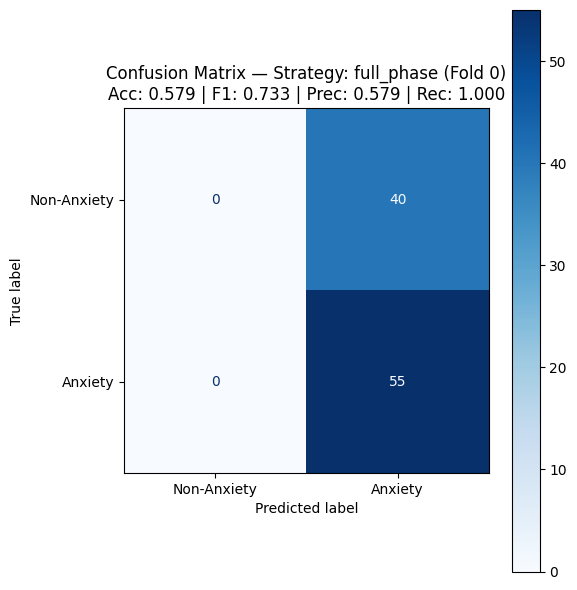

In [25]:
checkpoint = torch.load(
    os.path.join(CHECKPOINT_DIR, f"best_model_{STRATEGY}_fold{FOLD_IDX}.pt"),
    weights_only=False,
)
model.load_state_dict(checkpoint["model_state_dict"])

val_loss, val_acc, val_prec, val_rec, val_f1, preds, labels = validate(
    model, val_loader, criterion,
)

num_epochs_ran = len(history["train_loss"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history["train_loss"], label="Train Loss", color="#3b82f6")
axes[0].plot(history["val_loss"], label="Val Loss", color="#ef4444")
axes[0].axvline(x=best_epoch - 1, color="#10b981", linestyle="--", alpha=0.5, label=f"Best (ep {best_epoch})")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history["train_acc"], label="Train Acc", color="#3b82f6")
axes[1].plot(history["val_acc"], label="Val Acc", color="#ef4444")
axes[1].axvline(x=best_epoch - 1, color="#10b981", linestyle="--", alpha=0.5, label=f"Best (ep {best_epoch})")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history["val_f1"], label="F1", color="#10b981")
axes[2].plot(history["val_precision"], label="Precision", color="#f59e0b")
axes[2].plot(history["val_recall"], label="Recall", color="#8b5cf6")
axes[2].axvline(x=best_epoch - 1, color="#10b981", linestyle="--", alpha=0.5, label=f"Best (ep {best_epoch})")
axes[2].set_title("Validation Metrics")
axes[2].set_xlabel("Epoch")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle(
    f"DualStreamNet Training — Strategy: {STRATEGY} | Fold {FOLD_IDX} | "
    f"Stopped at epoch {num_epochs_ran}/{EPOCHS}",
    fontsize=14, fontweight="bold",
)
plt.tight_layout()
plt.show()

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Anxiety", "Anxiety"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(
    f"Confusion Matrix — Strategy: {STRATEGY} (Fold {FOLD_IDX})\n"
    f"Acc: {val_acc:.3f} | F1: {val_f1:.3f} | Prec: {val_prec:.3f} | Rec: {val_rec:.3f}"
)
plt.tight_layout()
plt.show()

In [26]:
final_path = os.path.join(CHECKPOINT_DIR, f"final_model_{STRATEGY}_fold{FOLD_IDX}.pt")

torch.save({
    "model_state_dict": model.state_dict(),
    "strategy": STRATEGY,
    "flow_channels": FLOW_CHANNELS,
    "mode": MODE,
    "history": history,
    "best_epoch": best_epoch,
    "best_val_loss": best_val_loss,
    "hyperparameters": {
        "epochs": EPOCHS,
        "epochs_ran": len(history["train_loss"]),
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "warmup_epochs": WARMUP_EPOCHS,
        "label_smoothing": LABEL_SMOOTHING,
        "grad_clip_norm": GRAD_CLIP_NORM,
        "early_stop_patience": EARLY_STOP_PATIENCE,
        "out_dim": OUT_DIM,
        "val_split": VAL_SPLIT,
        "k": K if STRATEGY == "window" else None,
        "target_length": TARGET_LENGTH if STRATEGY != "window" else None,
    },
}, final_path)

NameError: name 'VAL_SPLIT' is not defined